#DATA 620 Project 2
**Team 2:** Christophe Hunt, Joel Park, Ilya Kats, Pavan Akula, Nathan (Seoungyoon) Lim

###Project Description

The goal of the project is to create and analyze a two-node social network for sponsorship of bill and interests group affiliation within the U.S. Senate. Any mention of *bills* below implies *bills and resolutions*. Bills can be introduced by several senators, but only one, whose name appears first on the bill, is considered its sponsor. Senator may sponsor a bill for various reasons - because they support it, because they want to have a record of supporting it, because their constituents request it, and even to show support for bill's sponsor. Sometimes Senator may sponsor a bill to get campaign contributions to get elected to public office. Companies, labor unions, and other organizations spend billions of dollars each year on lobbying Congress and federal agencies. Before a bill is drafted Senator's staff, lobbyists and special interests groups work together tirelessly. Each bill is classified into a *subject* based on its *legislative* purpose. *For the purpose of this project we will be assuming bill classification is based on lobbying and special interests groups.* We will be analyzing the relationship between senators and special interests groups. This type of social networks are known as *affiliation* or *bipartite* networks.

Specific project requirements:

- Identify a large two-node network dataset. Data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as an island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?

###Data Source

For the project, we are analyzing sponsorship of bill and interests group affiliation within the U.S. Senate of the 114th Congress that met from January 3, 2015 to January 3, 2017. The official repository of the U.S. legislative data is Congress.gov. The bills data is also maintained by the U.S. Government Publishing Office. The data for the 114th Congress is available at https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/. The data is stored in XML format and contains a significant amount of metadata to describe a bill and its activity in Congress.

The public @unitedstates project maintains data and tools to access and analyze the governmental data including congressional data. Our primary data source is archived bills data from the 114th Congress prepared by the Sunlight Foundation. The data is saved in JSON format. Data access and format description is available at https://github.com/unitedstates/congress/wiki.

###Data Import

After downloading bills information from https://www.gpo.gov/fdsys/bulkdata/BILLSTATUS/114/, we have extracted required data and saved it to MySQL relational database on Google Cloud.

To reduce the size of the dataset we have used data of four Senators. Two Democratic and two Republican senators.
- Harry Reid(D-NV)
- Elizabeth Warren(D-MA)
- Mitch McConnell(R-KY)
- Jeff Sessions(R-AL), Current 84th Attorney General of the United States.
- Bernard Sanders(I-VT)

Additional information about lobbying can be found at 
- https://www.opensecrets.org/lobby/index.php
- http://www.lib.niu.edu/1976/ii761224.html


In [1]:
#Libraries used
import numpy as np
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

In [2]:
#Retrieve data from cloud database
sql_con = pymysql.connect(host='104.196.212.179', port=3306, user='root', passwd='data620pw', db='billsdata')

query = ("SELECT senator, `subject`, COUNT(1) AS billCount FROM "
        "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
        "FROM sponsors s "
        "JOIN subjects ss ON s.billid = ss.billid "
        "JOIN bills b ON s.billid = b.billid "
        "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
        "GROUP BY senator, `subject`;")

subjectInfo = pd.read_sql(query, con=sql_con)

query = ("SELECT DISTINCT A.senator AS senator_A, A.billCount AS billCount_A, "
         "B.senator AS senator_B, B.billCount AS billCount_B, A.`subject` AS `lobbyGroup` FROM "
         "(SELECT senator, `subject`, COUNT(1) AS billCount FROM "
         "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
         "FROM sponsors s "
         "JOIN subjects ss ON s.billid = ss.billid "
         "JOIN bills b ON s.billid = b.billid "
         "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
         "GROUP BY senator, `subject` ) A JOIN "
         "(SELECT senator, `subject`, COUNT(1) AS billCount FROM "
         "(SELECT DISTINCT b.billId, b.title, s.`name` AS senator, ss.mainSubject AS `subject` "
         "FROM sponsors s "
         "JOIN subjects ss ON s.billid = ss.billid "
         "JOIN bills b ON s.billid = b.billid "
         "WHERE s.`name` IN ('Harry Reid','Elizabeth Warren', 'Mitch McConnell','Jeff Sessions','Bernard Sanders') ) a "
         "GROUP BY senator, `subject` ) B "
         "ON A.`subject` = B.`subject` WHERE A.senator != B.senator ORDER BY A.senator, B.senator; ")

lobbyInfo = pd.read_sql(query, con=sql_con)

sql_con.close()

#Seperate data into senators and billsubject
senatorsList = subjectInfo.senator.unique()
subjectList = subjectInfo.subject.unique()

senatorsList = senatorsList.tolist()
subjectList = subjectList.tolist()

#Remove duplicates from lobby dataframe
lobbyFinalDf = lobbyInfo.query('billCount_A == 0')

for index, row in lobbyInfo.iterrows():
    s1 = row[0]
    b1 = row[1]
    s2 = row[2]
    b2 = row[3]
    l1 = row[4]
    e = False
    if ((lobbyFinalDf['senator_A'] == s1) & (lobbyFinalDf['senator_B'] == s2) & (lobbyFinalDf['lobbyGroup'] == l1)).any():
        e = True
    if ((lobbyFinalDf['senator_A'] == s2) & (lobbyFinalDf['senator_B'] == s1) & (lobbyFinalDf['lobbyGroup'] == l1)).any():
        e = True
    if not e:
        frames = [lobbyFinalDf, lobbyInfo[(lobbyInfo.senator_A == s1) & (lobbyInfo.senator_B == s2)  & (lobbyInfo.lobbyGroup == l1)]]
        lobbyFinalDf = pd.concat(frames)

###Classification of bills sponsored by Senator based on subject.

In [3]:
subjectInfo

,senator,subject,billCount
0,Bernard Sanders,Crime and law enforcement,2
1,Bernard Sanders,Economics and public finance,1
2,Bernard Sanders,Education,1
3,Bernard Sanders,Energy,4
4,Bernard Sanders,Environmental protection,1
5,Bernard Sanders,Finance and financial sector,1
6,Bernard Sanders,Government operations and politics,3
7,Bernard Sanders,Health,3
8,Bernard Sanders,Labor and employment,6
9,Bernard Sanders,Public lands and natural resources,1


###Two-mode Network Graph

Following graph shows two sets of nodes and relationships between sets. The first set of nodes are Senators and second set is a lobbying group. Sets of nodes are related, but there is no relation within each set of nodes.


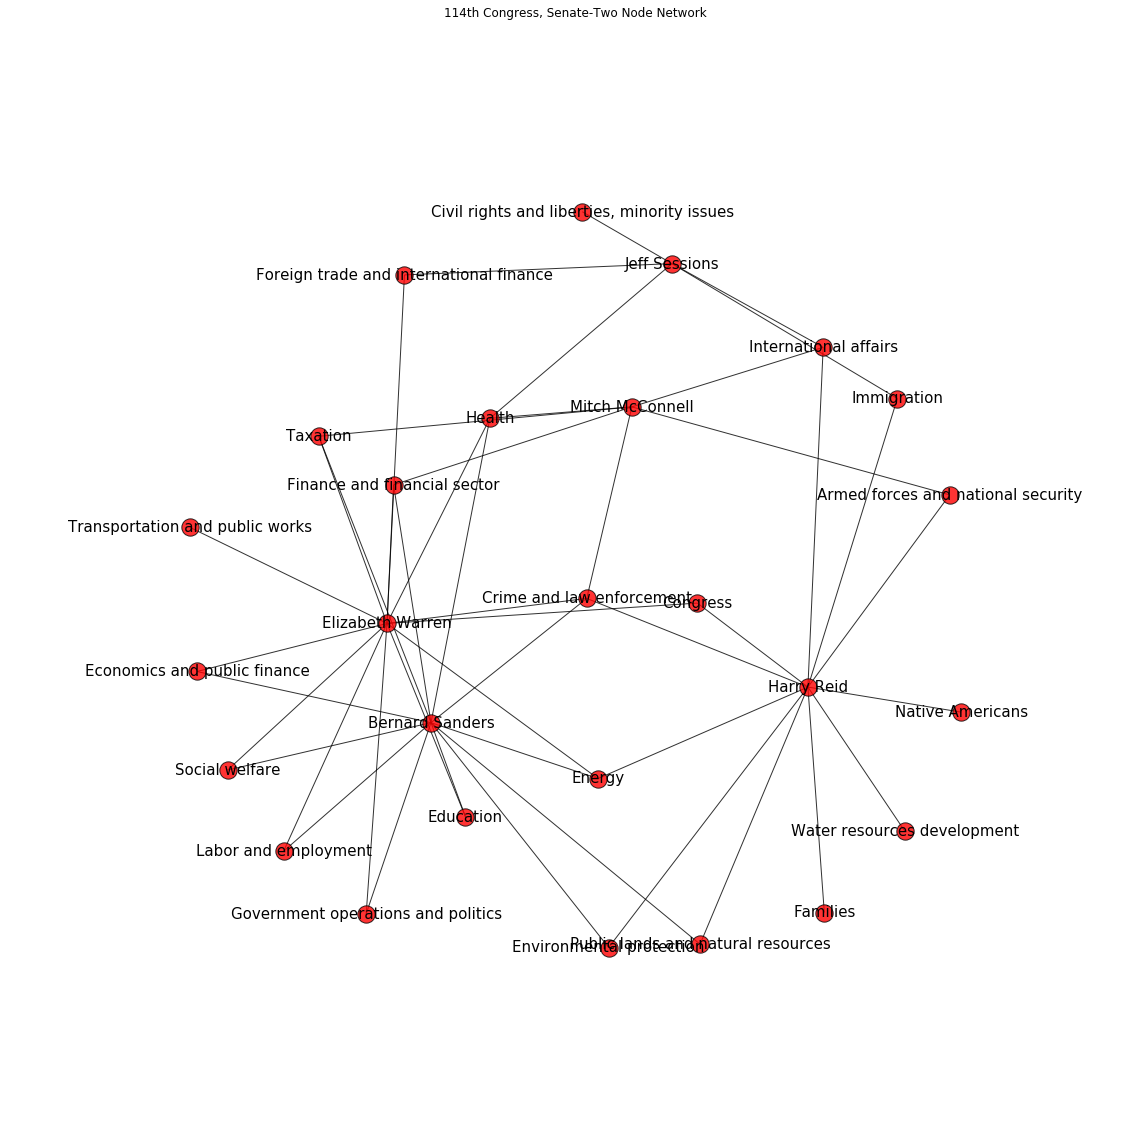

In [4]:
%matplotlib inline
fig = plt.figure(figsize=(15, 15))
B = nx.Graph()
B.add_nodes_from(senatorsList, bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(subjectList, bipartite=1)

for index, row in subjectInfo.iterrows():
    B.add_edge(row['senator'], row['subject'])

#pos = nx.spring_layout(B, k=0.5, iterations=2)
pos = nx.fruchterman_reingold_layout(B, k=0.2, iterations=75)
nx.draw(B, with_labels=True, pos=pos, font_size=15, alpha=.8)
plt.title('114th Congress, Senate-Two Node Network')
plt.show()

###Senators and Lobby Group

In [5]:
#Following table displays Senators and bills they sponsored that are tied to lobby group
lobbyFinalDf.sort_values(['lobbyGroup', 'senator_A', 'senator_B'], ascending = True, inplace=True)
lobbyFinalDf

,senator_A,billCount_A,senator_B,billCount_B,lobbyGroup
47,Harry Reid,2,Mitch McConnell,2,Armed forces and national security
29,Elizabeth Warren,1,Harry Reid,2,Congress
0,Bernard Sanders,2,Elizabeth Warren,1,Crime and law enforcement
10,Bernard Sanders,2,Harry Reid,1,Crime and law enforcement
15,Bernard Sanders,2,Mitch McConnell,2,Crime and law enforcement
30,Elizabeth Warren,1,Harry Reid,1,Crime and law enforcement
34,Elizabeth Warren,1,Mitch McConnell,2,Crime and law enforcement
48,Harry Reid,1,Mitch McConnell,2,Crime and law enforcement
1,Bernard Sanders,1,Elizabeth Warren,1,Economics and public finance
2,Bernard Sanders,1,Elizabeth Warren,1,Education


In [6]:
#Graph can be queried to get information about node sets
bottom_nodes, top_nodes = bipartite.sets(B)

#Total of 22 lobbying groups
print len(bottom_nodes)

#Lobbying groups
df = pd.DataFrame(list(bottom_nodes), columns=['Groups'])
df

22


,Groups
0,Armed forces and national security
1,Health
2,Government operations and politics
3,Economics and public finance
4,Families
5,Water resources development
6,Taxation
7,Immigration
8,Labor and employment
9,"Civil rights and liberties, minority issues"


In [7]:
#Total of 5 Senators
print len(top_nodes)

#Senators
df = pd.DataFrame(list(top_nodes), columns=['Senators'])
df

5


,Senators
0,Jeff Sessions
1,Harry Reid
2,Elizabeth Warren
3,Bernard Sanders
4,Mitch McConnell


In [8]:
#Get total number of nodes in the graph (Senators + Lobbying groups)
bipartite.sets(B)
nx.number_of_nodes(B)

27

In [9]:
#Diameter of the graph
print(B.size())

47


In [10]:
#Displays information how nodes are grouped inside the graph
#Senators bipartite value is 0 and Lobby group bipartite value is 1
df = pd.DataFrame(bipartite.color(B).items(), columns=['Node', 'bipartite'])
df.sort_values(['bipartite', 'Node'], ascending = True, inplace=True)
df

,Node,bipartite
19,Bernard Sanders,0
15,Elizabeth Warren,0
7,Harry Reid,0
11,Jeff Sessions,0
16,Mitch McConnell,0
0,Armed forces and national security,1
10,"Civil rights and liberties, minority issues",1
5,Congress,1
12,Crime and law enforcement,1
3,Economics and public finance,1


In [11]:
#Gives information about average shortest path between Senators and Lobbying groups
nx.average_shortest_path_length(B)

2.455840455840456

#Metrics and Inference

###Shortest Path

Function *shortest_path_length* of *NetworkX* library allows us to find the *Shortest Path* from a specific origin to a specified destination in a given network while minimizing the total cost associated with the path. 

In our case, *shortest path* metric provides information, if any lobbying group wants to bring a bill to the floor, they can either go through Senator Bernard Sanders or Senator Elizabeth Warren. On the other hand it lobbying groups go through Senator Jeff Sessions or Senator Mitch McConnell it will take longer.

Data we are analyzing is from 114th Congress which was in session from January 3, 2015, to January 3, 2017. It was also a Presidential election year, and Senator Bernard Sanders was running for President of United States. It could be a coincidence that Senator Bernard Sanders was trying to show the country that he can work with anyone and everyone.

In [12]:
#Shortest path between Senators
df = pd.DataFrame(bipartite.color(B).items(), columns=['Node', 'bipartite'])
df1 = df[(df.bipartite == 0)]
df2 = df[(df.bipartite == 1)]

cols = ['Senator', 'Group', 'ShortestPath']
lst = []
for i1, m1 in df1.iterrows():
    for i2, m2 in df2.iterrows():
        s1 = m1[0]
        s2 = m2[0]
        e = False
        if [s1, s2, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if [s2, s1, nx.shortest_path_length(B, s1, s2)] in lst:
            e = True
        if not e:
            lst.append([s1, s2, nx.shortest_path_length(B, s1, s2)])

ShortPath = pd.DataFrame(lst, columns=cols)
ShortPath.sort_values(['ShortestPath', 'Senator', 'Group'], ascending = True, inplace=True)
ShortPath

,Senator,Group,ShortestPath
98,Bernard Sanders,Crime and law enforcement,1
91,Bernard Sanders,Economics and public finance,1
109,Bernard Sanders,Education,1
104,Bernard Sanders,Energy,1
107,Bernard Sanders,Environmental protection,1
102,Bernard Sanders,Finance and financial sector,1
90,Bernard Sanders,Government operations and politics,1
89,Bernard Sanders,Health,1
96,Bernard Sanders,Labor and employment,1
108,Bernard Sanders,Public lands and natural resources,1


###Node centralities

We will be showing metrics
- Closeness - Closeness is the inverse sum of all shortest paths
- Betweenness - Number of shortest paths that pass through a node
- Degree - The number other nodes that a node is connected to

In our case, Senator Elizabeth Warren and Senator Bernard Sanders top the list in all three metrics. 

In [13]:
#Closeness centrality between Senetors and Lobby Group
close = nx.closeness_centrality(B)
df = pd.DataFrame(close.items(), columns=['Node', 'Closeness'])
df.sort_values(['Closeness', 'Node'], ascending = False, inplace=True)
df

,Node,Closeness
15,Elizabeth Warren,0.541667
14,Bernard Sanders,0.520000
12,Crime and law enforcement,0.509804
7,Harry Reid,0.500000
21,Energy,0.490566
1,Health,0.472727
20,Congress,0.472727
25,Public lands and natural resources,0.440678
24,Environmental protection,0.440678
6,Taxation,0.426230


In [14]:
#Betweenness centrality between Senetors and Lobby Group
between = nx.betweenness_centrality(B)
df = pd.DataFrame(between.items(), columns=['Node', 'Betweenness'])
df.sort_values(['Betweenness', 'Node'], ascending = False, inplace=True)
df

,Node,Betweenness
7,Harry Reid,0.362762
15,Elizabeth Warren,0.328706
14,Bernard Sanders,0.242275
26,Jeff Sessions,0.116570
1,Health,0.083842
12,Crime and law enforcement,0.079459
16,Mitch McConnell,0.075842
21,Energy,0.054371
23,International affairs,0.045737
20,Congress,0.031179


In [15]:
#Degrees centrality between Senetors and Lobby Group
degree = nx.degree_centrality(B)
df = pd.DataFrame(degree.items(), columns=['Node', 'Degrees'])
df.sort_values(['Degrees', 'Node'], ascending = False, inplace=True)
df

,Node,Degrees
15,Elizabeth Warren,0.500000
14,Bernard Sanders,0.461538
7,Harry Reid,0.423077
16,Mitch McConnell,0.230769
26,Jeff Sessions,0.192308
1,Health,0.153846
12,Crime and law enforcement,0.153846
6,Taxation,0.115385
23,International affairs,0.115385
18,Finance and financial sector,0.115385


###Projection

According to the article published by Tore Opsahl, on https://toreopsahl.com/tnet/two-mode-networks/, *Projection* is described as *transforming a two-mode network into a one-mode network*. The process works by selecting one set of nodes and linking two nodes if they are connected to the same node of the other set.

In our case, Lobbyist can become a Senator and sponsor a bill and vote on it. He can avoid entire lobbying group network, his/her staff members can directly talk to other senators staff members.

Some examples former lobbyists becoming Senators,

- Dan Coats, Republican Senator from Indiana, 1989 to 1999 and 2011 to 2017. He was worked as a lobbyist in 2007.
- John Thune, Republican Senator from South Dakota, worked as a lobbyist from 2003 to 2005.

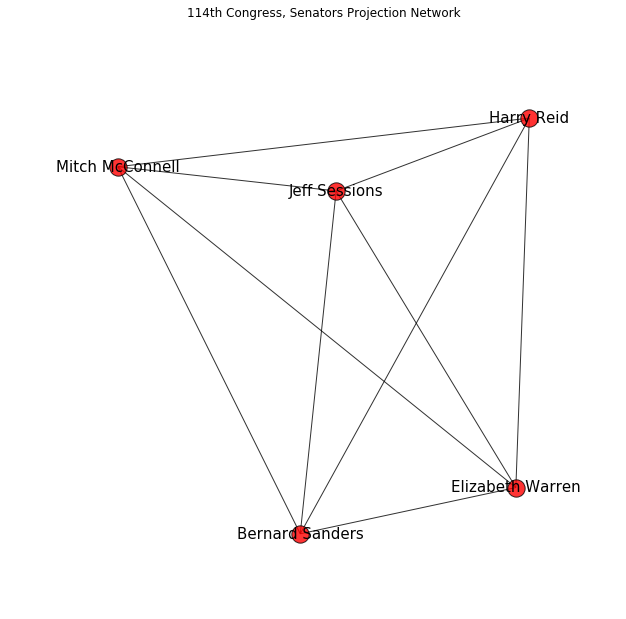

In [27]:
#Projection network of Senators, when two-mode network is into one-mode network 
G = bipartite.projected_graph(B, top_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(8, 8))

pos = nx.spring_layout(G, k=0.5, iterations=15)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8)
plt.title('114th Congress, Senators Projection Network')
plt.show()

Following network is projected graph of the lobby and special interest groups.

In our case, if a senators become lobbyist and have good attitude, then can help pass good bills. They can also build good connections and become influential power brokers in politics. 

The downside, in the current political environment, the lobbyist may have a hard time getting elected to public office.

Some examples former senators becoming lobbyists

- Evan Bayh, former Democratic senator from Indiana
- Tom Daschle, former Democratic senator from South Dakota
- Scott Brown, former Republican senator from Massachusetts
- Chuck Hagel, former Republican senator from Nebraska and former Secretary of Defense

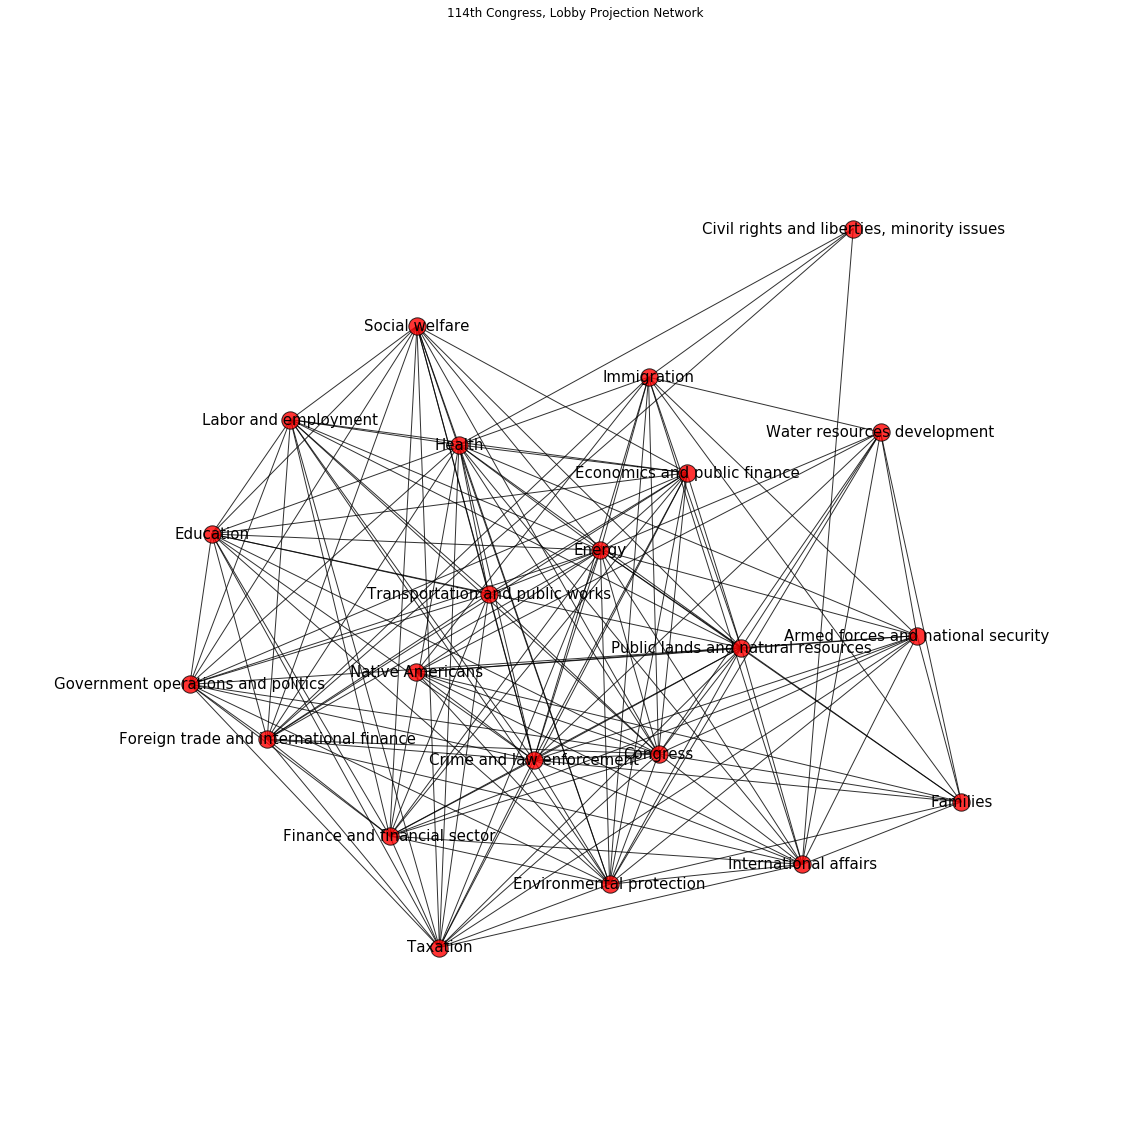

In [17]:
#Projection network of lobby and special intrest groups, when two-mode network is into one-mode network 
G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)

%matplotlib inline
fig = plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.5, iterations=15)
nx.draw(G, with_labels=True, pos=pos, font_size=15, alpha=.8)
plt.title('114th Congress, Lobby Projection Network')
plt.show()

###Density

A Dense graph is a graph in which the number of edges is close to the maximal number of edges. Following shows nodes in each node-set are even. Output suggests it is not a dense graph.

In [18]:
#Density
print(bipartite.density(B,top_nodes))

print(bipartite.density(B,bottom_nodes))


0.427272727273
0.427272727273


###Clustering

Following data show, there is no clustering when a complete network is analyzed. In this case, the network is analyzed as a one-mode network. This type of clustering metrics does not provide a complete picture.

In [19]:
c = nx.clustering(B)
df = pd.DataFrame(c.items(), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

,Node,Clustering
5,Water resources development,0.0
22,Transportation and public works,0.0
6,Taxation,0.0
19,Social welfare,0.0
25,Public lands and natural resources,0.0
13,Native Americans,0.0
16,Mitch McConnell,0.0
9,Labor and employment,0.0
26,Jeff Sessions,0.0
23,International affairs,0.0


Two-mode clustering metrics show there is a high level of clustering around lobby groups. Most Senators want to work with lobbying groups that are involved with social programs.

It may be a coincidence that during an election year, Senators were trying to bring bills to the floor that were associated with lobbying groups that involve in social programs.

Lobbying groups have high clustering compared to Senators. In other words, Senators are creating clusters around lobbying groups. We can assume that Senators were more active than lobbying groups.

In [20]:
c = bipartite.clustering(B)
df = pd.DataFrame(c.items(), columns=['Node', 'Clustering'])
df.sort_values(['Clustering', 'Node'], ascending = False, inplace=True)
df

,Node,Clustering
19,Social welfare,0.630952
2,Government operations and politics,0.630952
9,Labor and employment,0.630952
10,Education,0.630952
3,Economics and public finance,0.630952
5,Water resources development,0.541667
13,Native Americans,0.541667
4,Families,0.541667
6,Taxation,0.507292
18,Finance and financial sector,0.507292


###Local clustering coefficient for two-mode networks

In [21]:
#Average clustering Robins Alexander method
print(round(bipartite.robins_alexander_clustering(B), 3))

0.443


In [22]:
#Average clustering
print(round(bipartite.average_clustering(B), 3))

0.435


###Subgroups

This occurrence of situations in which the nodes of a graph fall into two or more groups with some nodes acting as links between the groups. Following table shows subgroup formation between two different node sets.

In [23]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3
a = get_triangles(B)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

,node1,node2,node3
0,Armed forces and national security,Health,Mitch McConnell
1,Armed forces and national security,Families,Harry Reid
2,Armed forces and national security,Congress,Harry Reid
3,Armed forces and national security,Crime and law enforcement,Harry Reid
4,Armed forces and national security,Crime and law enforcement,Mitch McConnell
5,Armed forces and national security,Finance and financial sector,Mitch McConnell
6,Armed forces and national security,Energy,Harry Reid
7,Armed forces and national security,International affairs,Mitch McConnell
8,Armed forces and national security,Environmental protection,Harry Reid
9,Health,Immigration,Jeff Sessions


###Cliques

A clique is defined as a maximal complete subgraph of a given graph. Example: a group of nodes where every node is connected directly to every other node. The word *maximal* means that no other nodes can be added to the clique without making it less connected.

When the entire two-node graph is checked for cliques, Senators ranked on the top. This explains Senator connecting to lobbying groups make a complete subgraph or a clique.

Senator Elizabeth Warren connects with more lobbying groups, creating more cliques.

In [24]:
c = nx.number_of_cliques(B)
df = pd.DataFrame(c.items(), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

,Node,Cliques
15,Elizabeth Warren,13
14,Bernard Sanders,12
7,Harry Reid,11
16,Mitch McConnell,6
26,Jeff Sessions,5
1,Health,4
12,Crime and law enforcement,4
6,Taxation,3
23,International affairs,3
18,Finance and financial sector,3


###On a projected graph, lobbying groups *Health, Energy, Crime and law enforcement and Congress* stand out. That means these lobbying groups are more popular among Senators.

In [25]:
G = bipartite.projected_graph(B, bottom_nodes, multigraph=False)
c = nx.number_of_cliques(G)
df = pd.DataFrame(c.items(), columns=['Node', 'Cliques'])
df.sort_values(['Cliques', 'Node'], ascending = False, inplace=True)
df

,Node,Cliques
1,Health,7
16,Energy,7
10,Crime and law enforcement,7
15,Congress,7
18,International affairs,6
6,Taxation,4
20,Public lands and natural resources,4
7,Immigration,4
12,Foreign trade and international finance,4
13,Finance and financial sector,4


###On a projected graph, following table, shows subgroups among lobbying groups. That means these lobbying groups are more popular among Senators and these lobbying groups tend to work with same Senators.

In [26]:
def get_triangles(g):
    nodes = g.nodes()
    for n1 in nodes:
        neighbors1 = set(g[n1])
        for n2 in filter(lambda x: x>n1, nodes):
            neighbors2 = set(g[n2])
            common = neighbors1 & neighbors2
            for n3 in filter(lambda x: x>n2, common):
                yield n1, n2, n3

a = get_triangles(G)
df = pd.DataFrame(a)
df.columns = ['node1', 'node2', 'node3']
df

,node1,node2,node3
0,Armed forces and national security,Health,Immigration
1,Armed forces and national security,Health,Public lands and natural resources
2,Armed forces and national security,Health,International affairs
3,Armed forces and national security,Health,Taxation
4,Armed forces and national security,Government operations and politics,Public lands and natural resources
5,Armed forces and national security,Government operations and politics,Health
6,Armed forces and national security,Government operations and politics,Taxation
7,Armed forces and national security,Economics and public finance,Energy
8,Armed forces and national security,Economics and public finance,Finance and financial sector
9,Armed forces and national security,Economics and public finance,Public lands and natural resources
